# Preparation

<b>Load Libraries</b>

In [7]:
# data structures
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
## settings
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_theme('notebook')

# models selection
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score

# metrics
from sklearn.metrics import fbeta_score, make_scorer

# pipeline
from imblearn.pipeline import Pipeline

# compose
from sklearn.compose import ColumnTransformer

# preprocessings
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, TargetEncoder
from category_encoders.cat_boost import CatBoostEncoder

# decomposition
from sklearn.decomposition import PCA

# features selection
from mlxtend.feature_selection import SequentialFeatureSelector

# resamplings
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

# algorithms
## linear_model
from sklearn.linear_model import LogisticRegression
## neighbors
from sklearn.neighbors import KNeighborsClassifier
## svm
from sklearn.svm import SVC
## tree
from sklearn.tree import DecisionTreeClassifier
## ensample
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# mlflow
import mlflow
from mlflow.models import infer_signature

# others
import re, joblib, os
from sklearn.base import BaseEstimator, TransformerMixin

In [8]:
# user-defined modules
##
cwd = os.getcwd()
os.chdir('../../../')

##
from usr_modules.mlflow_usr_defined import MLflowModel

##
os.chdir(cwd)

In [9]:
# model's type separation
parametric_models = ['LR']
non_parametric_models = ['KNN', 'SVM', 'CART']
ensample_models = ['ET', 'RF', 'GB', 'LGBM', 'XGB']

<b>Load Dataset</b>

In [10]:
# dataset
df_base = pd.read_csv('../../../dataset/cleaned/train.csv')

## 
num_cols = df_base.select_dtypes(np.number).columns.tolist()
cat_cols = df_base.select_dtypes('object').columns.tolist()[0:-1]

##
num_idxes = [i for i, name in enumerate(df_base.columns.tolist()) if name in num_cols]
cat_idxes = [i for i, name in enumerate(df_base.columns.tolist()) if name in cat_cols]

In [11]:
# cross validation
##
arr = df_base.values
le = LabelEncoder()

##
X, y = arr[:, :-1], le.fit_transform(arr[:, -1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=5)

<b>MLflow</b>

In [12]:
# server connection
mlflow.set_tracking_uri('http://127.0.0.1:5000/')

In [13]:
# experiment creation & conneting
experiment_name = 'Features Engineering'
try:
    mlflow.create_experiment(
        name=experiment_name, 
        artifact_location='mlflow/_artifacts_store'
    )
    mlflow.set_experiment(
        experiment_name=experiment_name
    )
except:
    print(f'\'{experiment_name}\' has already existed.')
    mlflow.set_experiment(
        experiment_name=experiment_name
    )

'Features Engineering' has already existed.


<b>User-Defined Functions</b>

In [14]:
# parsed names
def get_parsed_names(old_names: list, new_names: list) -> list:
    parsed_names = []

    for name in new_names:
        eles = [ele for ele in re.split('_', name) if ele != '']
        eles[1] = int(re.split('x', eles[1])[-1])

        if name != 'remainder':
            parsed_names.append(
                f'{old_names[eles[1]]}_{eles[-1]}'
            )
        else:
            parsed_names.append(f'{old_names[eles[1]]}')

    return parsed_names

In [15]:
# models
def load_base_models() -> list:
    models = []
    models.append(('LR', LogisticRegression(n_jobs=-1)))
    models.append(('KNN', KNeighborsClassifier(n_jobs=-1)))
    models.append(('SVM', SVC()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('ET', ExtraTreesClassifier(n_jobs=-1)))
    models.append(('RF', RandomForestClassifier(n_jobs=-1)))
    models.append(('GB', GradientBoostingClassifier()))
    models.append(('LGBM', LGBMClassifier(verbose=-1, n_jobs=-1)))
    models.append(('XGB', XGBClassifier(n_jobs=-1)))

    return models 

In [16]:
# pipelines
def get_pipelines(
        base_models: list,
        ohe: list=[], other_encoders: list=[],
        scaling: list=[], pca: list=[], resampling: list=[], 
) -> list:
    ## [<name>, <estimator>]
    steps_num_pro = scaling + pca + resampling
    num_pro = [('num_pro', Pipeline(steps_num_pro), num_idxes)]

    ## [<name>, <estimator>, <idxes>]
    cat_pro = ohe + other_encoders
        
    ##
    if len(steps_num_pro) != 0:
        transformers = num_pro + cat_pro
    else:
        transformers = cat_pro
    ct = [('transform', ColumnTransformer(transformers, remainder='passthrough'))]

    ##
    pipelines = []
    for name, model in base_models:
        steps = ct + [(name, model)]
        pipelines.append((name, Pipeline(steps)))
        
    return pipelines

In [17]:
# kflold results
def get_kfold_results(models: list, X: np.ndarray, y: np.ndarray) -> dict:
    ##
    kfold_results = dict()
    cv = RepeatedStratifiedKFold(
        n_splits=10, n_repeats=3, 
        random_state=7
    )
    scoring = make_scorer(fbeta_score, beta=2)

    ##
    for name, model in models:
        cv_results = cross_val_score(
            estimator=model, 
            X=X, y=y, 
            cv=cv, scoring=scoring
        )

        print(f'{name}: {cv_results.mean()} ({cv_results.std()})')
        kfold_results[name] = cv_results

    return kfold_results

In [18]:
# selected models
def get_selected_base_models(names_to_choose: list) -> list:
    models = load_base_models()
    selected_models = [(name, model) for name, model in models if name in names_to_choose]

    return selected_models

In [19]:
# kfold visualization
def plot_kfold_results(kfold_results: dict):
    ##
    data_to_plot = pd.DataFrame(kfold_results)

    ##
    new_idxes = data_to_plot.mean(axis=0)\
        .sort_values(ascending=False)\
            .index.tolist()
    data_to_plot = data_to_plot.reindex(
        labels=new_idxes, 
        axis=1
    )

    ##
    g = sns.boxplot(
        data_to_plot, 
        fill=False, 
        showmeans=True
    )
    for i in range(3):
        g.get_xticklabels()[i].set_fontweight('bold')
        g.get_xticklabels()[i].set_color('r')

<b>User-Defined Classes</b>

In [20]:
# class SFS Base
class FS_BaseUserDefinedTransformer(BaseEstimator, TransformerMixin):
    ## 
    def __init__(self, 
                 ohe=None, other_encoders=None,
                 scaling: list=[], factor_analysis: list=[]) -> None:
        ###
        self.scaling, self.factor_analysis = scaling, factor_analysis
        ### 
        self.ohe, self.other_encoders = ohe, other_encoders


    ##
    def _check_ndim(self, X: np.ndarray) -> tuple[np.ndarray, int]:
        ###
        if X.ndim == 2:
            X_ = X
            num_iters = X.shape[1]
        else:
            X_ = X.reshape(-1, 1)
            num_iters = 1

        return X_, num_iters
    
    ##
    def _category_detection(self, X: np.ndarray) -> tuple[list, list, np.ndarray]:
        ###
        num_idxes, cat_idxes = [], []

        ### check dimension
        X_, num_iters = self._check_ndim(X=X)

        ###
        for i in range(num_iters):
            try:
                X_[:1, i].astype(float)
                num_idxes.append(i)
            except:
                cat_idxes.append(i)
        
        return num_idxes, cat_idxes, X_
    
    ##
    def _get_transformers(self, cat_idxes: list=[], num_idxes: list=[]) -> list:
        if len(num_idxes) == 0:
            transformers = self.cat_pro
        elif len(cat_idxes) == 0:
            transformers = self.num_pro
        else:
            transformers = self.num_pro + self.cat_pro

        return transformers 
    
    ## 
    def fit(self, X: np.ndarray, y=None):
        ###
        transformers = self._get_transformers(self.cat_idxes, self.num_idxes)
        self.ct = ColumnTransformer(transformers, remainder='passthrough')
        self.ct.fit(self.X_fit_)

        return self
    
    ##
    def transform(self, X: np.ndarray, y=None):
        X_, _ = self._check_ndim(X=X)

        return self.ct.transform(X=X_)

In [21]:
# Onehot_Scaling_Pca
class SFS_OSP(FS_BaseUserDefinedTransformer):
    def fit(self, X: np.ndarray, y=None):
        ###
        self.num_idxes, self.cat_idxes, self.X_fit_ = self._category_detection(X)

        ###
        steps = self.scaling + self.factor_analysis
        self.num_pro = [('num_pro', Pipeline(steps), self.num_idxes)]

        self.cat_pro = [('cat_pro', self.ohe, self.cat_idxes)]

        ###
        super().fit(X=X)
        
        return self

# 1. Baseline Evaluation

In [74]:
## filter out warning
from warnings import simplefilter
simplefilter(action='ignore')

# base models
models = load_base_models()

## encoding
encoding = [('ohe', OneHotEncoder(drop='first', sparse_output=False), cat_idxes)]

## pipelines
pipelines = get_pipelines(
    base_models=models, 
    ohe=encoding
)

## kfold results
kfold_results = get_kfold_results(
    models=pipelines, 
    X=X_train, y=y_train
)

LR: 0.13228050685782308 (0.0541376961381269)
KNN: 0.3590482148333225 (0.08163408925075537)
SVM: 0.0 (0.0)
CART: 0.7230301704431803 (0.05565670801270096)
ET: 0.5110814016595057 (0.08318338444964417)
RF: 0.6616640743186097 (0.08292081282396639)
GB: 0.7641055177427308 (0.055433904832365224)
LGBM: 0.7904782196037831 (0.052733861062937704)
XGB: 0.7788322510027165 (0.056953790262783334)


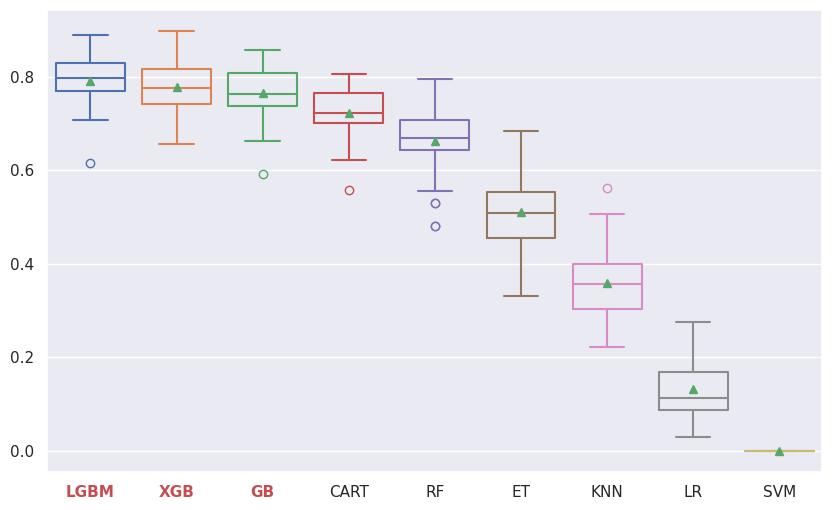

In [75]:
# visualizations
plot_kfold_results(
    kfold_results=kfold_results
)

In [76]:
# 
## filter out warning
from warnings import simplefilter
simplefilter(action='ignore')

## base model
models = load_base_models()

## encoding
ohe = [('ohe', OneHotEncoder(drop='first', sparse_output=False), cat_idxes)]

## pipelines
pipelines = get_pipelines(
    base_models=models, 
    ohe=ohe
)

## mlflow
for name, pipeline in pipelines:
    ###
    pipeline.fit(X_train, y_train)

    ###
    val_predictions = pipeline.predict(X_test)
    val_fbeta = fbeta_score(
        y_true=y_test, y_pred=val_predictions, 
        beta=2
    )

    ### mlflow
    with mlflow.start_run():
        ####
        mlflow.set_tags(
            {
                'pipeline': 'OneHot', 
                'base_model': name
            }
        )

        ####
        mlflow.log_metrics(
            {
                'avg_fbeta': kfold_results[name].mean(), 
                'val_fbeta': val_fbeta
            }
        )

        ####
        mlflow.sklearn.log_model(
            sk_model=pipeline, 
            artifact_path=name
        )

# 2. Encoding && Scaling

<b>OneHot && Standardization</b>

In [3]:
# artifacts' path
artifacts_path = dict()
artifacts_path['feature_selector'] = '../../_artifacts/ohe_std.joblib'
artifacts_path['model'] = '../../_artifacts/ohe_std_lgbm.joblib'

In [78]:
## warnings
from warnings import simplefilter
simplefilter(action='ignore')

## transformers: standardize
transformers = SFS_OSP(
    ohe=OneHotEncoder(drop='first', sparse_output=False), 
    scaling=[('scaling', StandardScaler())]
)
## base model
base_model = get_selected_base_models(
    names_to_choose=['LGBM']
)

## pipeline
pipeline = Pipeline(
    steps=[('transformers', transformers)] + base_model
)

## sfs: forward
sfs = SequentialFeatureSelector(
    estimator=pipeline, 
    k_features='best', forward=True, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7),
    scoring=make_scorer(fbeta_score, beta=2), 
    verbose=2
)
sfs.fit(X_train, y_train)
joblib.dump(
    value=sfs, 
    filename=artifacts_path['feature_selector']
)

## save
pipeline.fit(sfs.transform(X_train), y_train)
joblib.dump(
    value=pipeline, 
    filename=artifacts_path['model']
)


[2024-07-25 15:51:32] Features: 1/19 -- score: 0.2381489118845433
[2024-07-25 15:51:54] Features: 2/19 -- score: 0.42408191254368577
[2024-07-25 15:52:16] Features: 3/19 -- score: 0.5754211684925191
[2024-07-25 15:52:40] Features: 4/19 -- score: 0.6225729598342019
[2024-07-25 15:53:03] Features: 5/19 -- score: 0.6584611009627147
[2024-07-25 15:53:25] Features: 6/19 -- score: 0.66052986385995
[2024-07-25 15:53:48] Features: 7/19 -- score: 0.6617499533205715
[2024-07-25 15:54:07] Features: 8/19 -- score: 0.6601361994499585
[2024-07-25 15:54:26] Features: 9/19 -- score: 0.7311445443588926
[2024-07-25 15:54:44] Features: 10/19 -- score: 0.7990904116019475
[2024-07-25 15:55:03] Features: 11/19 -- score: 0.8020770922467613
[2024-07-25 15:55:20] Features: 12/19 -- score: 0.8020770922467613
[2024-07-25 15:55:35] Features: 13/19 -- score: 0.8005928428259913
[2024-07-25 15:55:47] Features: 14/19 -- score: 0.8008545466925517
[2024-07-25 15:56:00] Features: 15/19 -- score: 0.8014141696172937
[202

['../../_artifacts/ohe_std_lgbm.joblib']

In [79]:
# model logging
##
val_predictions = pipeline.predict(sfs.transform(X_test))
val_fbeta = fbeta_score(
    y_true=y_test, y_pred=val_predictions, 
    beta=2
)

## mlflow
with mlflow.start_run():
    ###
    mlflow.set_tags(
        {
            'pipeline': 'OneHot && Scaling(standardize)', 
            'base_model': 'LGBM', 
            'feature_selection': 'true'
        }
    )

    ###
    mlflow.log_metrics(
        {
            'avg_fbeta': sfs.k_score_, 
            'val_fbeta': val_fbeta
        }
    )

    ###
    mlflow.pyfunc.log_model(
        artifact_path='LGBM', 
        python_model=MLflowModel(), 
        artifacts=artifacts_path, 
        signature=infer_signature(X_train), 
        pip_requirements=['joblib', 'mlxtend', 'scikit-learn']
    )

<b>OneHot && PowerTransformation</b>

In [81]:
# artifacts's path
artifacts_path['feature_selector'] = '../../_artifacts/ohe_powertransform.joblib'
artifacts_path['model'] = '../../_artifacts/ohe_powertransform_lgbm.joblib'

In [82]:
#
## warnings
from warnings import simplefilter
simplefilter(action='ignore')

## transformers
transformers = SFS_OSP(
    ohe=OneHotEncoder(drop='first', sparse_output=False), 
    scaling=[('scaling', PowerTransformer(method='yeo-johnson', standardize=True))]
)

## base model
base_model = get_selected_base_models(
    names_to_choose=['LGBM']
)

## pipeline
pipeline = Pipeline(
    steps=[('transformers', transformers)] + base_model
)

## sfs: forward
sfs = SequentialFeatureSelector(
    estimator=pipeline, 
    k_features='best', forward=True, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7),
    scoring=make_scorer(fbeta_score, beta=2), 
    verbose=2
)
sfs.fit(X_train, y_train)
joblib.dump(
    value=sfs, 
    filename=artifacts_path['feature_selector']
)

## save
pipeline.fit(sfs.transform(X_train), y_train)
joblib.dump(
    value=pipeline, 
    filename=artifacts_path['model']
)


[2024-07-25 15:58:12] Features: 1/19 -- score: 0.23735039060793678
[2024-07-25 15:58:36] Features: 2/19 -- score: 0.42582041867224146
[2024-07-25 15:59:00] Features: 3/19 -- score: 0.5774183734798274
[2024-07-25 15:59:26] Features: 4/19 -- score: 0.6238530809892006
[2024-07-25 15:59:53] Features: 5/19 -- score: 0.6581735954421309
[2024-07-25 16:00:21] Features: 6/19 -- score: 0.6586658214158743
[2024-07-25 16:00:57] Features: 7/19 -- score: 0.7236601632131298
[2024-07-25 16:01:08] Features: 8/19 -- score: 0.8006204713894784
[2024-07-25 16:01:32] Features: 9/19 -- score: 0.8043225746011307
[2024-07-25 16:01:54] Features: 10/19 -- score: 0.8054731887556635
[2024-07-25 16:02:16] Features: 11/19 -- score: 0.8090817933195367
[2024-07-25 16:02:35] Features: 12/19 -- score: 0.8090817933195367
[2024-07-25 16:02:53] Features: 13/19 -- score: 0.8045225948431872
[2024-07-25 16:03:09] Features: 14/19 -- score: 0.8039057746144053
[2024-07-25 16:03:22] Features: 15/19 -- score: 0.8016731581905101
[

['../../_artifacts/ohe_powertransform_lgbm.joblib']

In [84]:
# mlflow
##
val_predictions = pipeline.predict(sfs.transform(X_test))
val_fbeta = fbeta_score(
    y_true=y_test, y_pred=val_predictions, 
    beta=2
)

##
with mlflow.start_run():
    ###
    mlflow.set_tags(
        {
            'pipeline': 'OneHot && Scaling(power transform)', 
            'base_model': 'LGBM', 
            'feature_selection': 'true'
        }
    )

    ###
    mlflow.log_metrics(
        {
            'avg_fbeta': sfs.k_score_, 
            'val_fbeta': val_fbeta
        }
    )

    ###
    mlflow.pyfunc.log_model(
        artifact_path='LGBM', 
        python_model=MLflowModel(), 
        artifacts=artifacts_path, 
        signature=infer_signature(X_train), 
        pip_requirements=['joblib', 'mlxtend', 'scikit-learn']
    )

<b>OneHot && QuantileTransformatin</b>

In [18]:
# artifacts' path 
artifacts_path['feature_selector'] = '../../_artifacts/ohe_quantiletransform.joblib'
artifacts_path['model'] = '../../_artifacts/ohe_quantiletransform_lgbm.joblib'

In [19]:
#
## warnings
from warnings import simplefilter
simplefilter(action='ignore')

## transformers
transformers = SFS_OSP(
    ohe=OneHotEncoder(drop='first', sparse_output=False), 
    scaling=[('scaling', QuantileTransformer(output_distribution='normal'))]
)

## base model
base_model = get_selected_base_models(
    names_to_choose=['LGBM']
)

## pipeline
pipeline = Pipeline(
    steps=[('transformers', transformers)] + base_model
)

## sfs: forward
sfs = SequentialFeatureSelector(
    estimator=pipeline, 
    k_features='best', forward=True, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7), 
    scoring=make_scorer(fbeta_score, beta=2), 
    verbose=2
)
sfs.fit(X_train, y_train)

joblib.dump(
    value=sfs, 
    filename=artifacts_path['feature_selector']
)

##
pipeline.fit(sfs.transform(X_train), y_train)
joblib.dump(
    value=pipeline, 
    filename=artifacts_path['model']
)


[2024-07-26 09:53:32] Features: 1/19 -- score: 0.23645564657585305
[2024-07-26 09:54:05] Features: 2/19 -- score: 0.4220726154953954
[2024-07-26 09:54:41] Features: 3/19 -- score: 0.5765331982466577
[2024-07-26 09:55:22] Features: 4/19 -- score: 0.623949584845233
[2024-07-26 09:56:02] Features: 5/19 -- score: 0.6516358179604785
[2024-07-26 09:56:56] Features: 6/19 -- score: 0.6626550158392714
[2024-07-26 09:57:23] Features: 7/19 -- score: 0.7365166966759648
[2024-07-26 09:58:04] Features: 8/19 -- score: 0.7948174207609834
[2024-07-26 09:58:45] Features: 9/19 -- score: 0.804334197354321
[2024-07-26 09:59:26] Features: 10/19 -- score: 0.804334197354321
[2024-07-26 10:00:06] Features: 11/19 -- score: 0.8043036212839862
[2024-07-26 10:00:44] Features: 12/19 -- score: 0.80524396203364
[2024-07-26 10:01:19] Features: 13/19 -- score: 0.8029602268374475
[2024-07-26 10:02:03] Features: 14/19 -- score: 0.8045730508613071
[2024-07-26 10:02:17] Features: 15/19 -- score: 0.8056417463137108
[2024-0

['../../_artifacts/ohe_quantiletransform_lgbm.joblib']

In [21]:
# mlflow
##
val_predictions = pipeline.predict(sfs.transform(X_test))
val_fbeta = fbeta_score(
    y_true=y_test, y_pred=val_predictions, 
    beta=2
)

##
with mlflow.start_run():
    ###
    mlflow.set_tags(
        {
            'pipeline': 'OneHot && Scaling(quantile transform)', 
            'base_model': 'LGBM', 
            'feature_selection': 'true'
        }
    )

    ###
    mlflow.log_metrics(
        {
            'avg_fbeta': sfs.k_score_, 
            'val_fbeta': val_fbeta
        }
    )

    ###
    mlflow.pyfunc.log_model(
        artifact_path='LGBM', 
        python_model=MLflowModel(), 
        artifacts=artifacts_path, 
        signature=infer_signature(X_train), 
        pip_requirements=['joblib', 'mlxtend', 'scikit-learn']
    )

# 3. Encoding && Scaling && PCA

<b>OneHot && QuantileTransform && PCA(90%)

In [28]:
# artifacts' path
artifacts_path['feature_selector'] = '../../_artifacts/ohe_quantiletransform_pca.joblib'
artifacts_path['model'] = '../../_artifacts/ohe_quantiletransform_pca_lgbm.joblib'

In [30]:
#
## warnings
from warnings import simplefilter
simplefilter(action='ignore')

##
transformers = SFS_OSP(
    ohe=OneHotEncoder(drop='first', sparse_output=False), 
    scaling=[('scaling', QuantileTransformer())], factor_analysis=[('pca', PCA(n_components=0.9))]
)

##
base_model = get_selected_base_models(
    names_to_choose=['LGBM']
)

## 
pipeline = Pipeline(
    steps=[('transformers', transformers)] + base_model
)

## sfs: forwanrd
sfs = SequentialFeatureSelector(
    estimator=pipeline, 
    k_features='best', forward=True, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7), 
    scoring=make_scorer(fbeta_score, beta=2), 
    verbose=2
)
sfs.fit(X_train, y_train)
joblib.dump(
    value=sfs, 
    filename=artifacts_path['feature_selector']
)

##
pipeline.fit(sfs.transform(X_train), y_train)
joblib.dump(
    value=pipeline, 
    filename=artifacts_path['model']
)


[2024-07-26 10:32:08] Features: 1/19 -- score: 0.23651254705174793
[2024-07-26 10:32:38] Features: 2/19 -- score: 0.40588183110059217
[2024-07-26 10:33:12] Features: 3/19 -- score: 0.5457852406831913
[2024-07-26 10:33:48] Features: 4/19 -- score: 0.6007576151755125
[2024-07-26 10:34:24] Features: 5/19 -- score: 0.6201483829446932
[2024-07-26 10:35:00] Features: 6/19 -- score: 0.648909468722092
[2024-07-26 10:35:37] Features: 7/19 -- score: 0.6787024518104643
[2024-07-26 10:36:16] Features: 8/19 -- score: 0.6831594533511679
[2024-07-26 10:36:53] Features: 9/19 -- score: 0.7182931025993571
[2024-07-26 10:37:32] Features: 10/19 -- score: 0.7180892090239053
[2024-07-26 10:38:20] Features: 11/19 -- score: 0.7106651408595411
[2024-07-26 10:38:41] Features: 12/19 -- score: 0.7145689716125239
[2024-07-26 10:39:15] Features: 13/19 -- score: 0.7120427665208019
[2024-07-26 10:39:45] Features: 14/19 -- score: 0.6374091794970835
[2024-07-26 10:40:12] Features: 15/19 -- score: 0.6286493388232757
[2

['../../_artifacts/ohe_quantiletransform_pca_lgbm.joblib']

In [31]:
# mlflow
##
val_predictions = pipeline.predict(sfs.transform(X_test))
val_fbeta = fbeta_score(
    y_true=y_test, y_pred=val_predictions, 
    beta=2
)

##
with mlflow.start_run():
    ##
    mlflow.set_tags(
        {
            'pipeline': 'ohe_quantiletransform_pca(90%)', 
            'base_model': 'LGBM', 
            'feature_selection': 'true', 
            'pca': '90%'
        }
    )

    ##
    mlflow.log_metrics(
        {
            'avg_fbeta': sfs.k_score_, 
            'val_fbeta': val_fbeta
        }
    )

    ##
    mlflow.pyfunc.log_model(
        artifact_path='LGBM', 
        python_model=MLflowModel(), 
        artifacts=artifacts_path, 
        signature=infer_signature(X_train), 
        pip_requirements=['joblib', 'mlxtend', 'scikit-learn']
    )

# 4. Encoding && Scaling && Resampling

<b>OneHot && QuantileTransform && RandomOverSampling</b>

In [28]:
# artifacts' path
artifacts_path['feature_selector'] = '../../_artifacts/ohe_quantiletransform.joblib'
artifacts_path['model'] = '../../_artifacts/ohe_quantiletransform_ros_lgbm.joblib'

In [30]:
#
##
sfs = joblib.load(
    filename=artifacts_path['feature_selector']
)
selected_X_train = sfs.transform(X_train)

## transformers 
transformers = SFS_OSP(
    ohe=OneHotEncoder(drop='first', sparse_output=False), 
    scaling=[('scaling', QuantileTransformer(output_distribution='normal'))]
)

## resamplers
resampler = [('ROS', RandomOverSampler(sampling_strategy='auto'))]

## base model
base_model = get_selected_base_models(
    names_to_choose=['LGBM']
)

## pipeline
pipeline = Pipeline(
    steps=[('transformers', transformers)] + resampler + base_model
)

## kfold result
kfold_result = cross_val_score(
    estimator=pipeline, 
    X=selected_X_train, y=y_train, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7), 
    scoring=make_scorer(fbeta_score, beta=2)
)
print(f'ROS: {kfold_result.mean()} ({kfold_result.std()})')

##
pipeline.fit(selected_X_train, y_train)
joblib.dump(
    value=pipeline, 
    filename=artifacts_path['model']
)

ROS: 0.8255052774354766 (0.04609514196870448)


['../../_artifacts/ohe_quantiletransform_ros_lgbm.joblib']

In [32]:
# mlflow
##
val_predictions = pipeline.predict(sfs.transform(X_test))
val_fbeta = fbeta_score(
    y_true=y_test, y_pred=val_predictions, 
    beta=2
)

##
with mlflow.start_run():
    ###
    mlflow.set_tags(
        {
            'pipeline': 'ohe_quantiletransform_ros', 
            'base_model': 'LGBM', 
            'feature_selection': 'true',
            'resampling': 'ros'
        }
    )

    ###
    mlflow.log_metrics(
        {
            'avg_fbeta': kfold_result.mean(), 
            'val_fbeta': val_fbeta
        }
    )

    ###
    mlflow.pyfunc.log_model(
        artifact_path='LGBM', 
        python_model=MLflowModel(), 
        artifacts=artifacts_path, 
        signature=infer_signature(X_train), 
        pip_requirements=['joblib', 'mlxtend', 'scikit-learn']
    )

<b>OneHot && QuantileTransform && SMOTE</b>

In [4]:
# artifacts' path
artifacts_path['feature_selector'] = '../../_artifacts/ohe_quantiletransform.joblib'
artifacts_path['model'] = '../../_artifacts/ohe_quantiletransform_smote_lgbm.joblib'

In [22]:
#
##
sfs = joblib.load(
    filename=artifacts_path['feature_selector']
)
selected_X_train = sfs.transform(X_train)

## transformers
transformers = SFS_OSP(
    ohe=OneHotEncoder(drop='first', sparse_output=False), 
    scaling=[('scaling', QuantileTransformer(output_distribution='normal'))]
)

## resampler
resampler = [('SMOTE', SMOTE(sampling_strategy='auto'))]

## base model
base_model = get_selected_base_models(
    names_to_choose=['LGBM']
)

## pipeline
pipeline = Pipeline(
    steps=[('transformers', transformers)] + resampler + base_model
)
kfold_result = cross_val_score(
    estimator=pipeline, 
    X=selected_X_train, y=y_train, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7), 
    scoring=make_scorer(fbeta_score, beta=2)
)
print(f'LGBM: {kfold_result.mean()} ({kfold_result.std()})')

##
pipeline.fit(selected_X_train, y_train)
joblib.dump(
    value=pipeline, 
    filename=artifacts_path['model']
)

LGBM: 0.8116760496895696 (0.06306210112960636)


['../../_artifacts/ohe_quantiletransform_smote_lgbm.joblib']

In [24]:
# mlflow
##
val_predictions = pipeline.predict(sfs.transform(X_test))
val_fbeta = fbeta_score(
    y_true=y_test, y_pred=val_predictions, 
    beta=2
)

##
with mlflow.start_run():
    ###
    mlflow.set_tags(
        {
            'pipeline': 'ohe_quantiletransform_smote', 
            'base_model': 'LGBM', 
            'feature_selection': 'true', 
            'resampling': 'smote'
        }
    )

    ###
    mlflow.log_metrics(
        {
            'avg_fbeta': kfold_result.mean(), 
            'val_fbeta': val_fbeta
        }
    )

    ###
    mlflow.pyfunc.log_model(
        artifact_path='LGBM', 
        python_model=MLflowModel(), 
        artifacts=artifacts_path, 
        signature=infer_signature(X_train), 
        pip_requirements=['joblib', 'mlxtend', 'scikit-learn']
    )